<a href="https://colab.research.google.com/github/pachterlab/BLCSBGLKP_2020/blob/master/notebooks/diagnostic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diagnostic results

In [1]:
!git clone https://github.com/pachterlab/BLCSBGLKP_2020.git

Cloning into 'BLCSBGLKP_2020'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 133 (delta 25), reused 78 (delta 10), pack-reused 0
Receiving objects: 100% (133/133), 31.31 MiB | 25.77 MiB/s, done.
Resolving deltas: 100% (25/25), done.


In [2]:
!pip install anndata

     |████████████████████████████████| 102kB 2.2MB/s 


# Obtain diagnostic results from the adata

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import anndata

from collections import defaultdict
from collections import OrderedDict


from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import matplotlib.patches as mpatches



from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy.special import expit as sigmoid

def nd(arr):
    return np.asarray(arr).reshape(-1)

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

def main(X, y1, y2):
    y = np.asarray([y1, y2]).T
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=43)
    clf = LogisticRegression(random_state=43, dual=False, max_iter=1000, tol=1e-6)
    clf.fit(X_train, y_train[:,0])

    y_pred = clf.predict(X_test)
    
    # T = True, F = False, P = Positive,  N = Negative
    # Model Precision: TP/(TP+FP)
    # Model Recall: TP/(TP+FN)
    
    print("Score:     {:,.4f}".format(clf.score(X_test, y_test[:,0].astype(int))))
    print("Precision: {:,.4f}".format(metrics.precision_score(y_test[:,0].astype(int), y_pred.astype(int))))
    print("Recall:    {:,.4f}".format(metrics.recall_score(y_test[:,0].astype(int), y_pred.astype(int))))
    
    w = clf.coef_[0]
    b = clf.intercept_[0]

    return (X_train, X_test, y_train, y_test, y_pred, w, b, clf)

def plot(X, y, xidx, yidx, xlabel, ylabel, w, b):

    
    N = 1000
    r = 0.2
    
    # Get the test data
    c = nd(np.log1p(y[:,1]))
    x = nd(X[:,xidx])
    y = nd(X[:,yidx])
    
    
    # Find the limits
    xlims = (np.min(x)*(1-r), np.max(x)*(1+r))
    ylims = (np.min(y)*(1-r), np.max(y)*(1+r))
    
    # compute boundary line
    xx = np.linspace(*xlims, len(x))
    yy = (-xx*w[xidx] - b)/w[yidx]
    
    X, Y = np.meshgrid(np.linspace(*xlims, N), np.linspace(*ylims, N))
    YY = (-X*w[xidx] - b)/w[yidx]
    
    ###############################################################
    ax.set_xlim(*xlims)
    ax.set_ylim(*ylims)
    
    ### Scatter plot of points
    sc = ax.scatter(x, y, c = c,s=100, edgecolors="black", cmap="Greys")
    
    ### Plot boundary line
    # note that here we solve the above equation for y using the
    # coefficients and the intercept
    ax.plot(xx, yy, linestyle="--", color="black", linewidth=2, label="Log. reg. boundary")
    
    ### Plot logistic function
    # Perpendicular from the line is the probability that a sample
    # has viral RNA. This function is the logistic function and has
    # the form f(x) = 1/(1+exp(-(x-x0))) but we only care about variation
    # perpendicular to the line so we use Y and YY
    Z = sigmoid(Y-YY)
    # Since we want probability of 1 to be above the line, we do 1-Z
    cs = ax.imshow(Z, vmin = 0., vmax = 1., cmap=plt.cm.coolwarm, origin='lower', 
               extent=[*xlims, *ylims])
    
    #### Colorbar for RNA amount
    plt.colorbar(sc,  label="log(Viral RNA molecules + 1)")
    # Colorbar for Probability
    plt.colorbar(cs, label="Probability of + Virus")
    
    
    ###############################################################
    ## Prettying up the plot, adding 
    pos = mpatches.Patch(color="#D43F3A", label='$+$ Viral RNA')
    neg = mpatches.Patch(color="#3182bd", label='$-$ Viral RNA')
    handles, labels = ax.get_legend_handles_labels()
    handles.append(neg); handles.append(pos)
    ax.legend(handles=handles[::-1])
    
    ax.set_xlabel("log({}+1) amplicon counts".format(xlabel))
    ax.set_ylabel("log({}+1) amplicon counts".format(ylabel))
    
    ax.set_xlabel("log({}+1) amplicon counts".format("Spikein"))
    ax.set_ylabel("log({}+1) amplicon counts".format("Viral"))
    
    ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    plt.tight_layout(h_pad=1)
    ax.set_title("Logistic regression classifier on test data")
    return ax

def plot_LOD_adjusted(X_test, y_test, xlabel, ylabel, xidx, yidx, w, b, y_pred):
    x = np.exp(X_test[:,xidx])
    y = np.exp(X_test[:,yidx])
    c = pd.Series(y_pred).map(cm)
    
    xx = y_test[:,1]
    # xx[xx==0] = 0.1
    # yy = y*w[yidx] + x*(w[xidx])
    yy = (y**w[yidx])/(x**(-w[xidx]))
    
    
    ax.scatter(xx, yy, c=c)
    
    ### Make the plot pretty
    ax.set_xscale("symlog")
    ax.set_yscale("symlog")
    
    # bc = ax.axhline(y=np.exp(-b), linestyle="--", label="Log. reg. boundary", color="k")
    
    ax.set_xlabel(r"Viral RNA molecules")
    ax.set_ylabel(r"({}+1)^({:,.2f}) / ({}+1)^({:,.2f})".format(ylabel,w[yidx], xlabel,w[xidx]))

    ax.set_ylabel(r"({}+1)^({:,.2f}) / ({}+1)^({:,.2f})".format("Viral",w[yidx], "Spikein",w[xidx]))

    # legend
    pos = mpatches.Patch(color="#D43F3A", label='$+$ Viral RNA predicted')
    neg = mpatches.Patch(color="#3182bd", label='$-$ Viral RNA predicted')
    ax.legend(handles=[pos, neg])
    ax.set_title("Adjusted normalization based on logistic regression")
    return ax

def plot_LOD_normal(X_test, y_test, xlabel, ylabel, xidx, yidx, w, b, y_pred):
    x = np.exp(X_test[:,xidx])
    y = np.exp(X_test[:,yidx])
    c = pd.Series(y_pred).map(cm)
    
    xx = y_test[:,1]
    # xx[xx==0] = 0.1
    yy = y/x
    
    ax.scatter(xx, yy, c=c)
    
    ### Make the plot pretty
    ax.set_xscale("symlog")
    ax.set_yscale("symlog")
    ax.set_xlabel(r"Viral RNA molecules")
    ax.set_ylabel(r"({}+1) / ({}+1))".format(ylabel, xlabel))

    ax.set_ylabel(r"({}+1) / ({}+1))".format("Viral", "Spikein"))

    # legend
    pos = mpatches.Patch(color="#D43F3A", label='$+$ Viral RNA predicted')
    neg = mpatches.Patch(color="#3182bd", label='$-$ Viral RNA predicted')
    ax.legend(handles=[pos, neg])
    
    ax.set_title("Standard normalization")
    return ax

cm = {1:"#D43F3A", 0:"#3182bd"}
fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


## Load results

In [0]:
adata = anndata.read_h5ad("BLCSBGLKP_2020/data/kb/adata.h5ad")

## Diagnostic testing

We restrict our analysis to Plate1	HEK293	N	ATCC_RNA

We also drop the S genes since they were used in plate 2 only.

# We restrict our diagnostic analysis to Plate1	HEK293	N	ATCC_RNA

Other examples are shown after.

In [0]:
# Plate1	HEK293	N	ATCC_RNA

In [6]:
a = np.logical_and((adata.obs.plate=="Plate1").values, (adata.obs.lysate=="HEK293").values)
b = np.logical_and(a, adata.obs.Twist.values==0)
c = np.logical_and(b, adata.obs.ATCC_viral.values==0)

data = adata[b]

data.obs["sick"] = (data.obs.ATCC_RNA>0).astype(int)
data = data[:,np.logical_or(~data.var.gene.str.contains("_S"), data.var.gene.str.contains("RPP30"))]
#data = data[:,data.var.sort_values("gene").index]

X = np.log1p(data.layers["raw"])
y1 = nd(data.obs.sick.values.astype(int))
y2 = nd(data.obs.ATCC_RNA.values)

Trying to set attribute `.obs` of view, copying.


We split our data in half. We train a logistic regression model on the training half, and test out our model on the testing half. 
For the sake of downstream plotting, we append the Twist RNA values to the real classificaation for each sample to make a  `sample x 2` matrix. This results in y_test having two columns. When splitting the data into training and testing the Twist RNA values associated with the split samples are retained. Since `n_samples > n_genes` we set dual=False in the logistic regresion classification since we are not interested in solving using the dual formulation of the regularization. The equation of the line is $w_1*x + w_2*y = b$.

In [7]:
data

View of AnnData object with n_obs × n_vars = 140 × 5 
    obs: 'bcs', 'ecs', 'cnt', 'plate', 'well', 'lysate', 'Twist', 'ATCC_RNA', 'ATCC_viral', 'Twist_bool', 'ATCC_viral_bool', 'ATCC_RNA_bool', 'sick'
    var: 'gene'
    obsm: 'X_pca'
    layers: 'log1p', 'norm', 'raw', 'scale'

In [8]:
data.var

,gene
0,N1
1,N1_spikein
2,RPP30
3,S2
4,S2_spikein


In [10]:
(X_train, X_test, y_train, y_test, y_pred, w, b, clf) = main(X, y1, y2)

Score:     0.9571
Precision: 1.0000
Recall:    0.9388


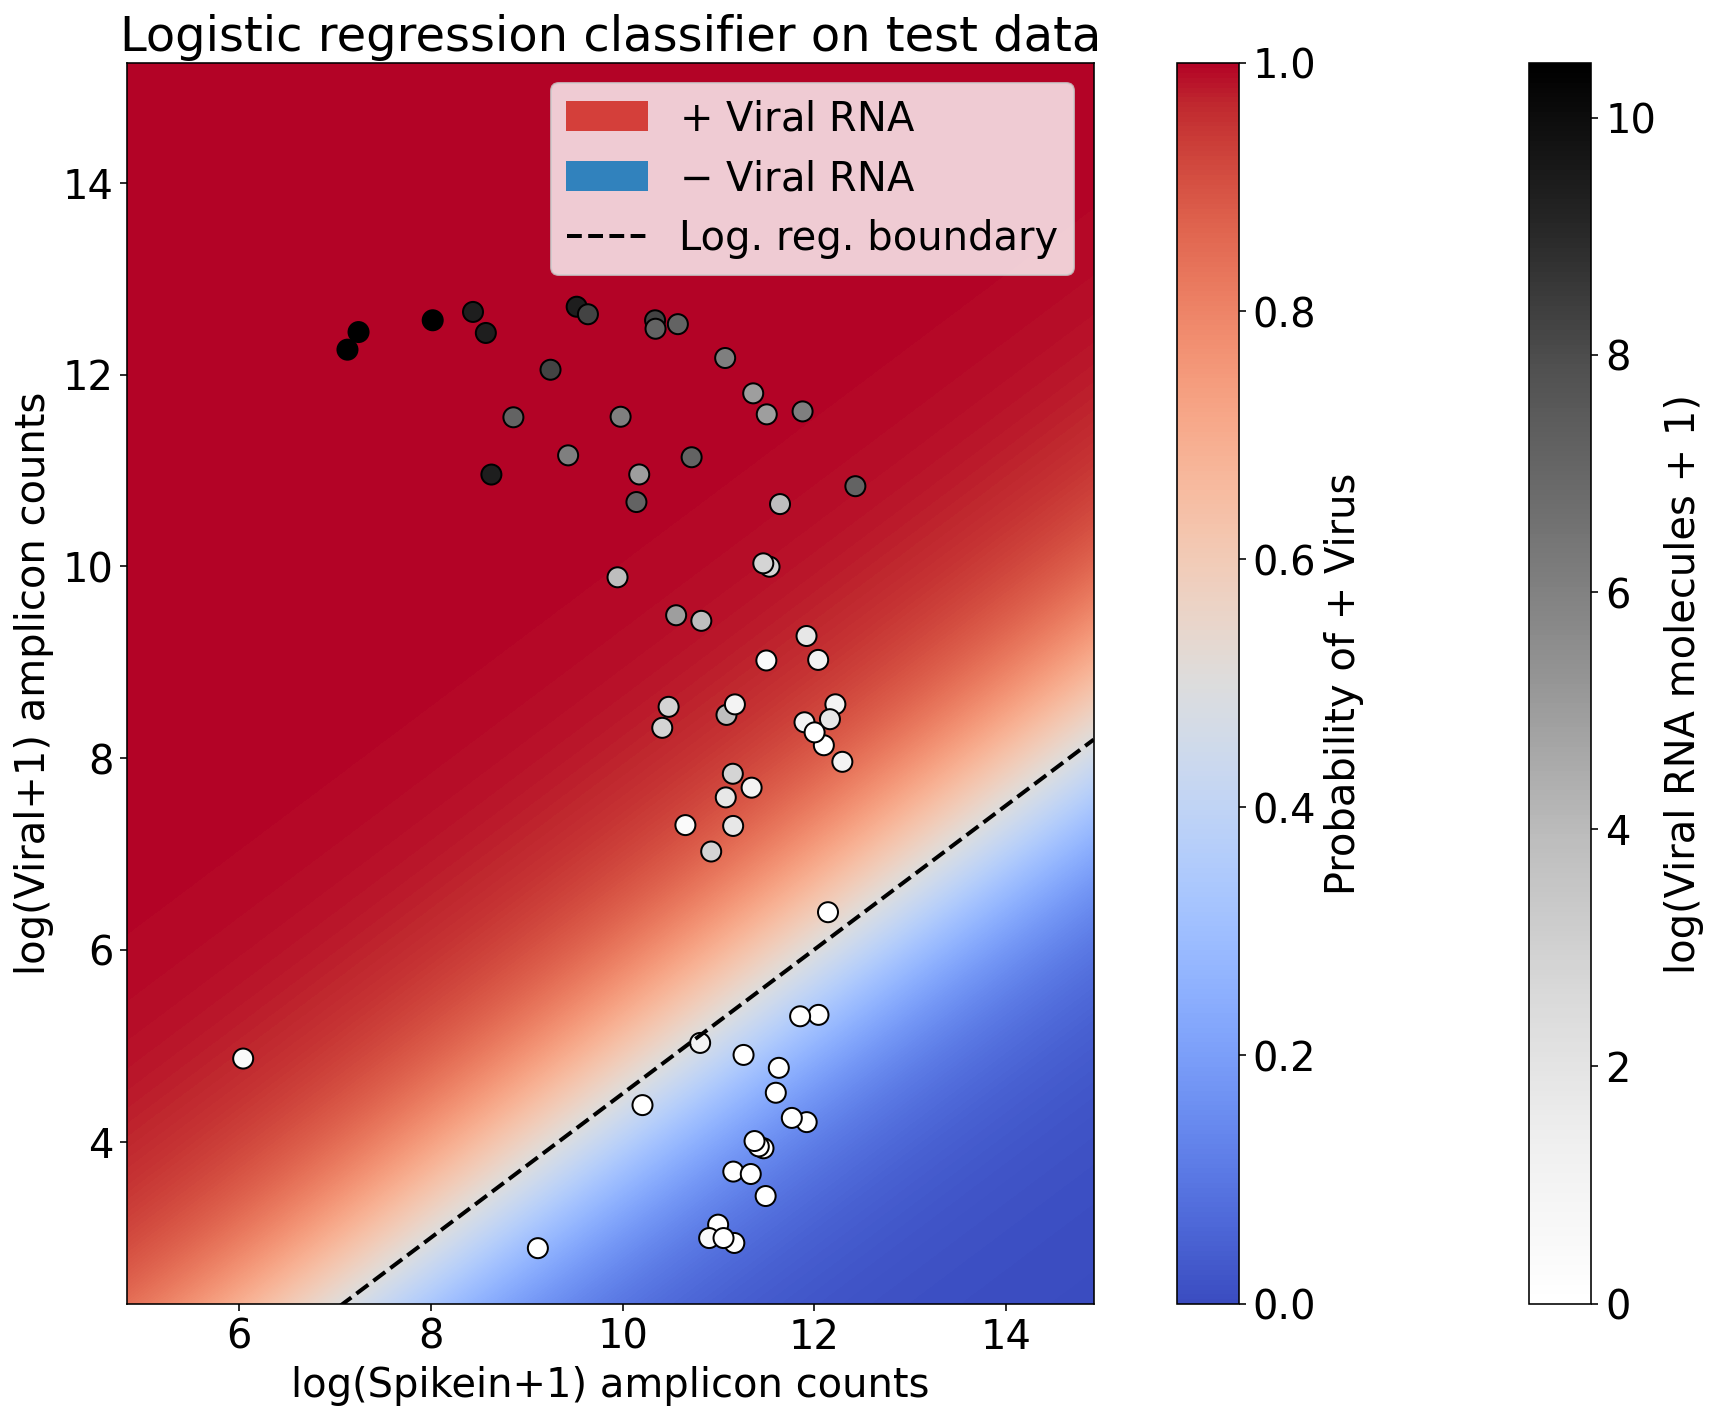

In [11]:
fig, ax = plt.subplots(figsize=(15,10))

xlabel, ylabel = ("N1_spikein", "N1")
xidx, yidx = (np.where(data.var.gene.values==xlabel)[0][0], np.where(data.var.gene.values==ylabel)[0][0])
    
plot(X_test, y_test, xidx, yidx, xlabel, ylabel, w, b)

plt.show()

### Examine relative counts

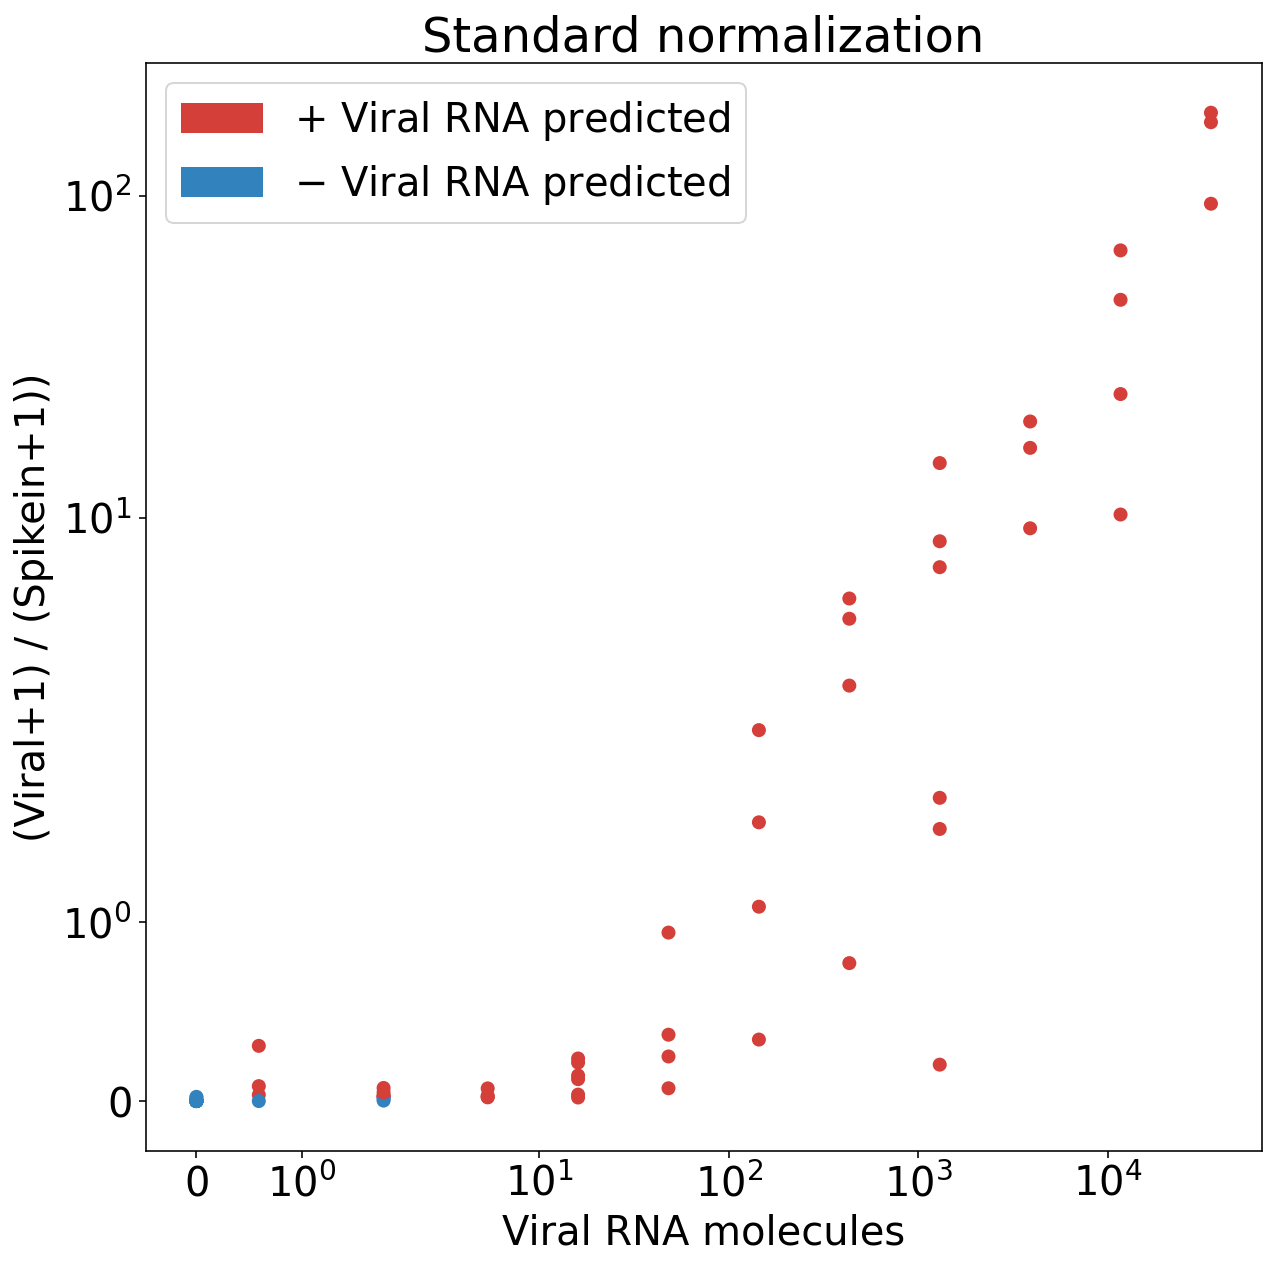

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))

xlabel, ylabel = ("N1_spikein", "N1")
xidx, yidx = (np.where(data.var.gene.values==xlabel)[0][0], np.where(data.var.gene.values==ylabel)[0][0])

plot_LOD_normal(X_test, y_test, xlabel, ylabel, xidx, yidx, w, b, y_pred)

plt.show()

### Adjusted relative abundances

The logistic regression was performed on the log(X+1) counts and the train/test/split gives back matrices that are log(X+1). In order to make plotting nicer (ie loglog scale axis), we exponentiate the matrices. Given $X_l = \log(X+1)$  we wish to plot $\frac{(Y+1)^{w_2}}{(X+1)^{w_1}}$ vs the amount of Twist RNA. We can plot $\frac{(Y+1)^{w_2}}{(X+1)^{w_1}} = \frac{exp(Y_l)^{w_2}}{exp(X_l)^{w_1}}$ vs the amount of Twist RNA. 

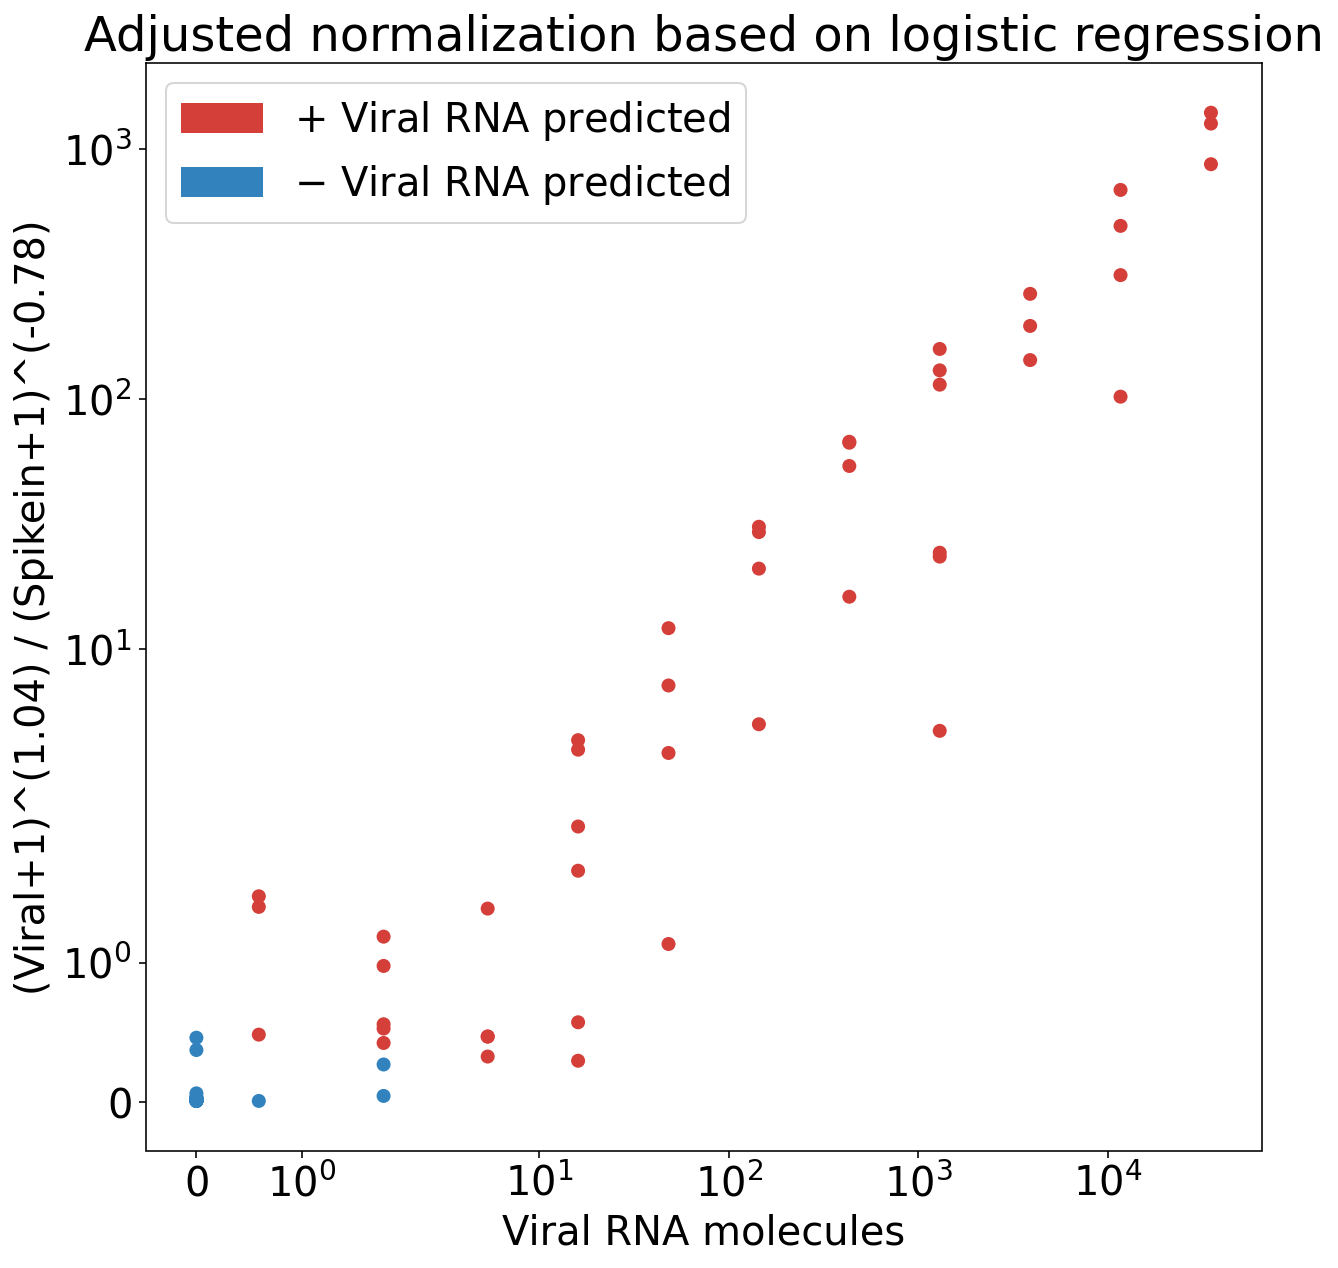

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))

xlabel, ylabel = ("N1_spikein", "N1")
xidx, yidx = (np.where(data.var.gene.values==xlabel)[0][0], np.where(data.var.gene.values==ylabel)[0][0])

plot_LOD_adjusted(X_test, y_test, xlabel, ylabel, xidx, yidx, w, b, y_pred)

plt.show()

In [14]:
print("Precision: {:,.4f}".format(metrics.precision_score(y_test[:,0], y_pred)))
print("Recall:    {:,.4f}".format(metrics.recall_score(y_test[:,0], y_pred)))

Precision: 1.0000
Recall:    0.9388


# Make these plots for all HEK experiments

In [0]:
exp = [
        ("Plate1", "HEK293", "N1", "Twist"), 
        ("Plate1", "HEK293", "N1", "ATCC_RNA"),
        ("Plate2", "HEK293", "S2", "Twist"), 
        ("Plate2", "HEK293", "S2", "ATCC_RNA"),
]

In [16]:
adata.var

,gene
0,N1
1,N1_spikein
2,RPP30
3,S2
4,S2_spikein


Plate1	HEK293	N	Twist
Score:     0.8333
Precision: 0.7391
Recall:    0.8947


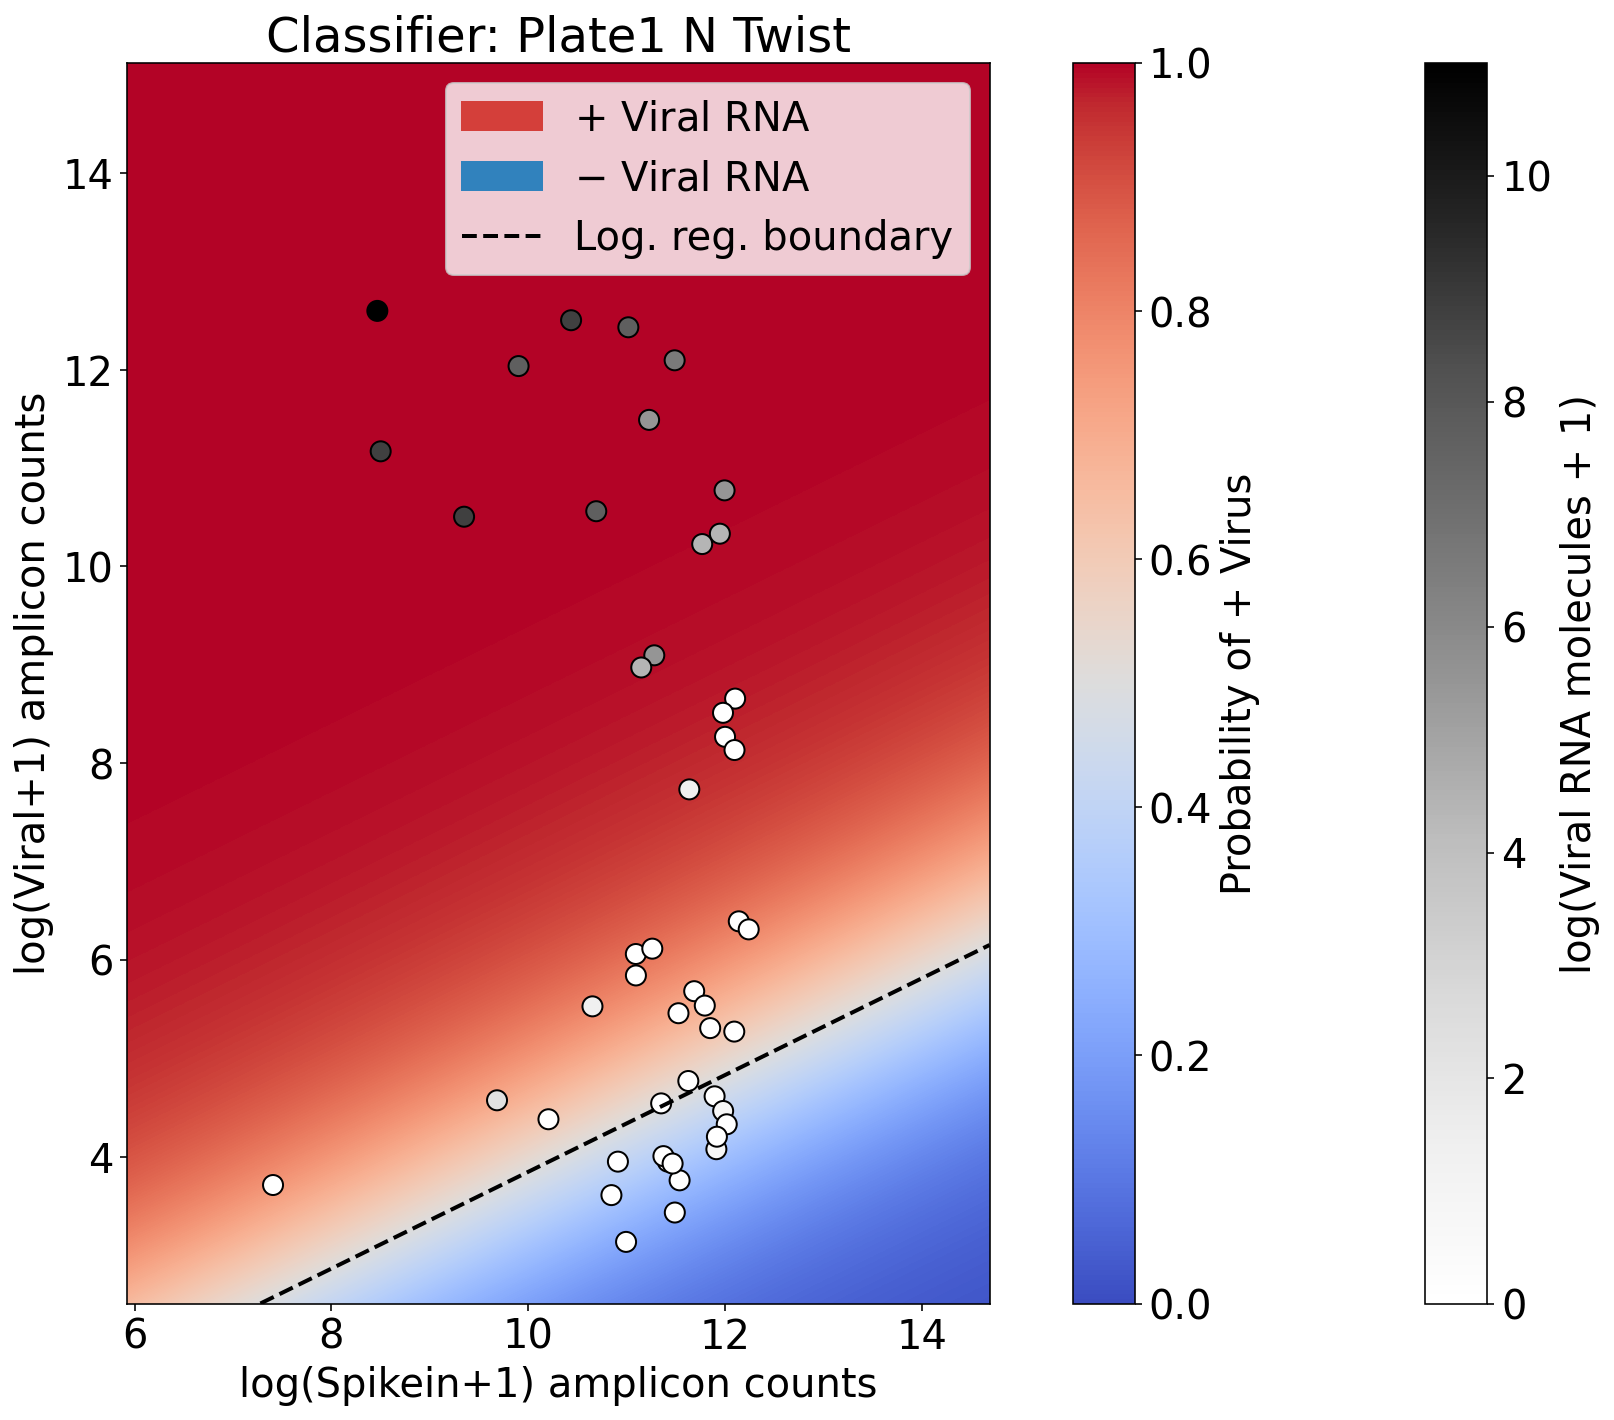

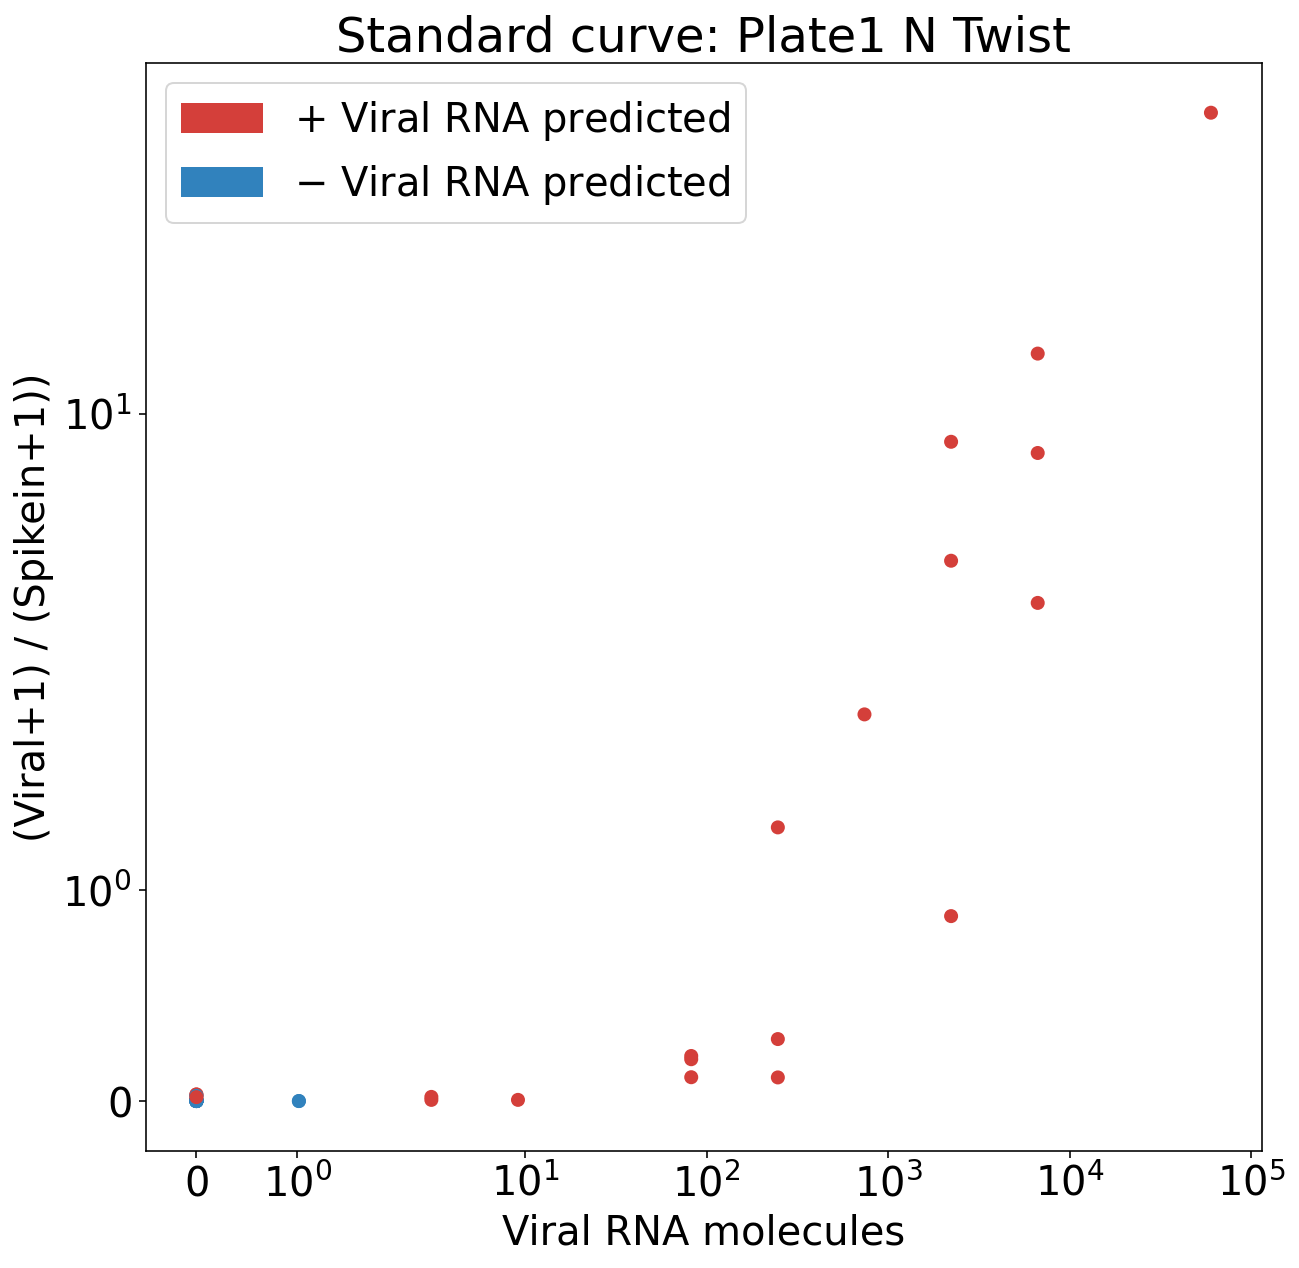

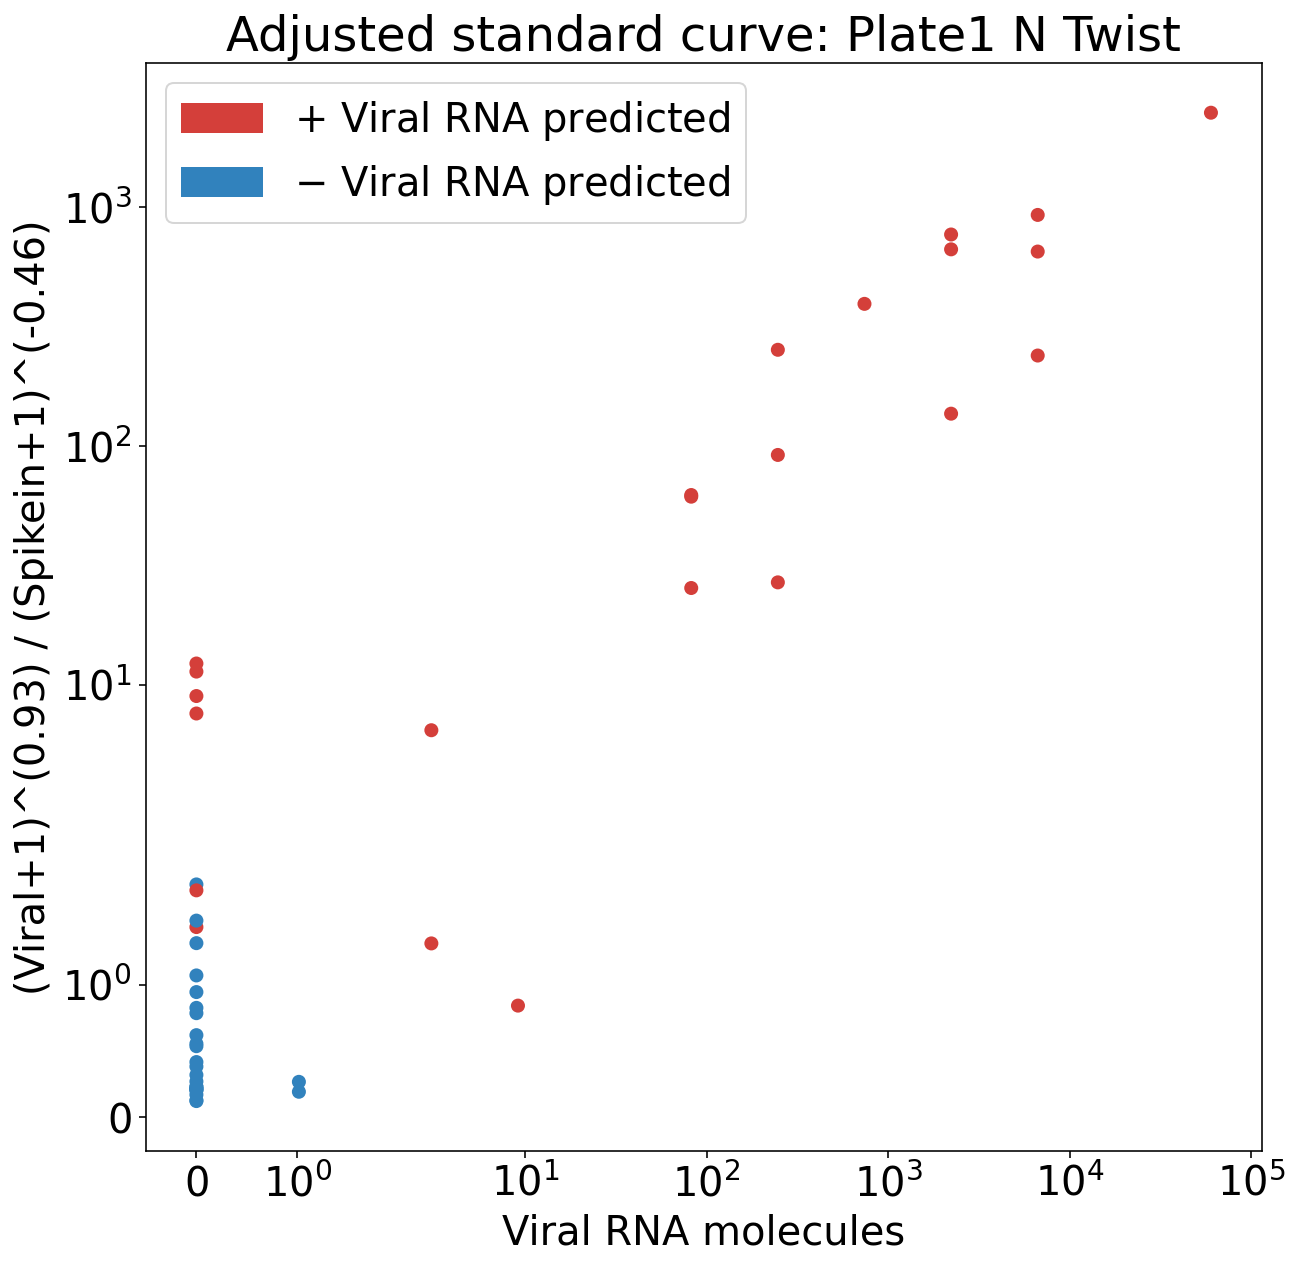

Plate1	HEK293	N	ATCC_RNA
Score:     0.9571
Precision: 1.0000
Recall:    0.9388


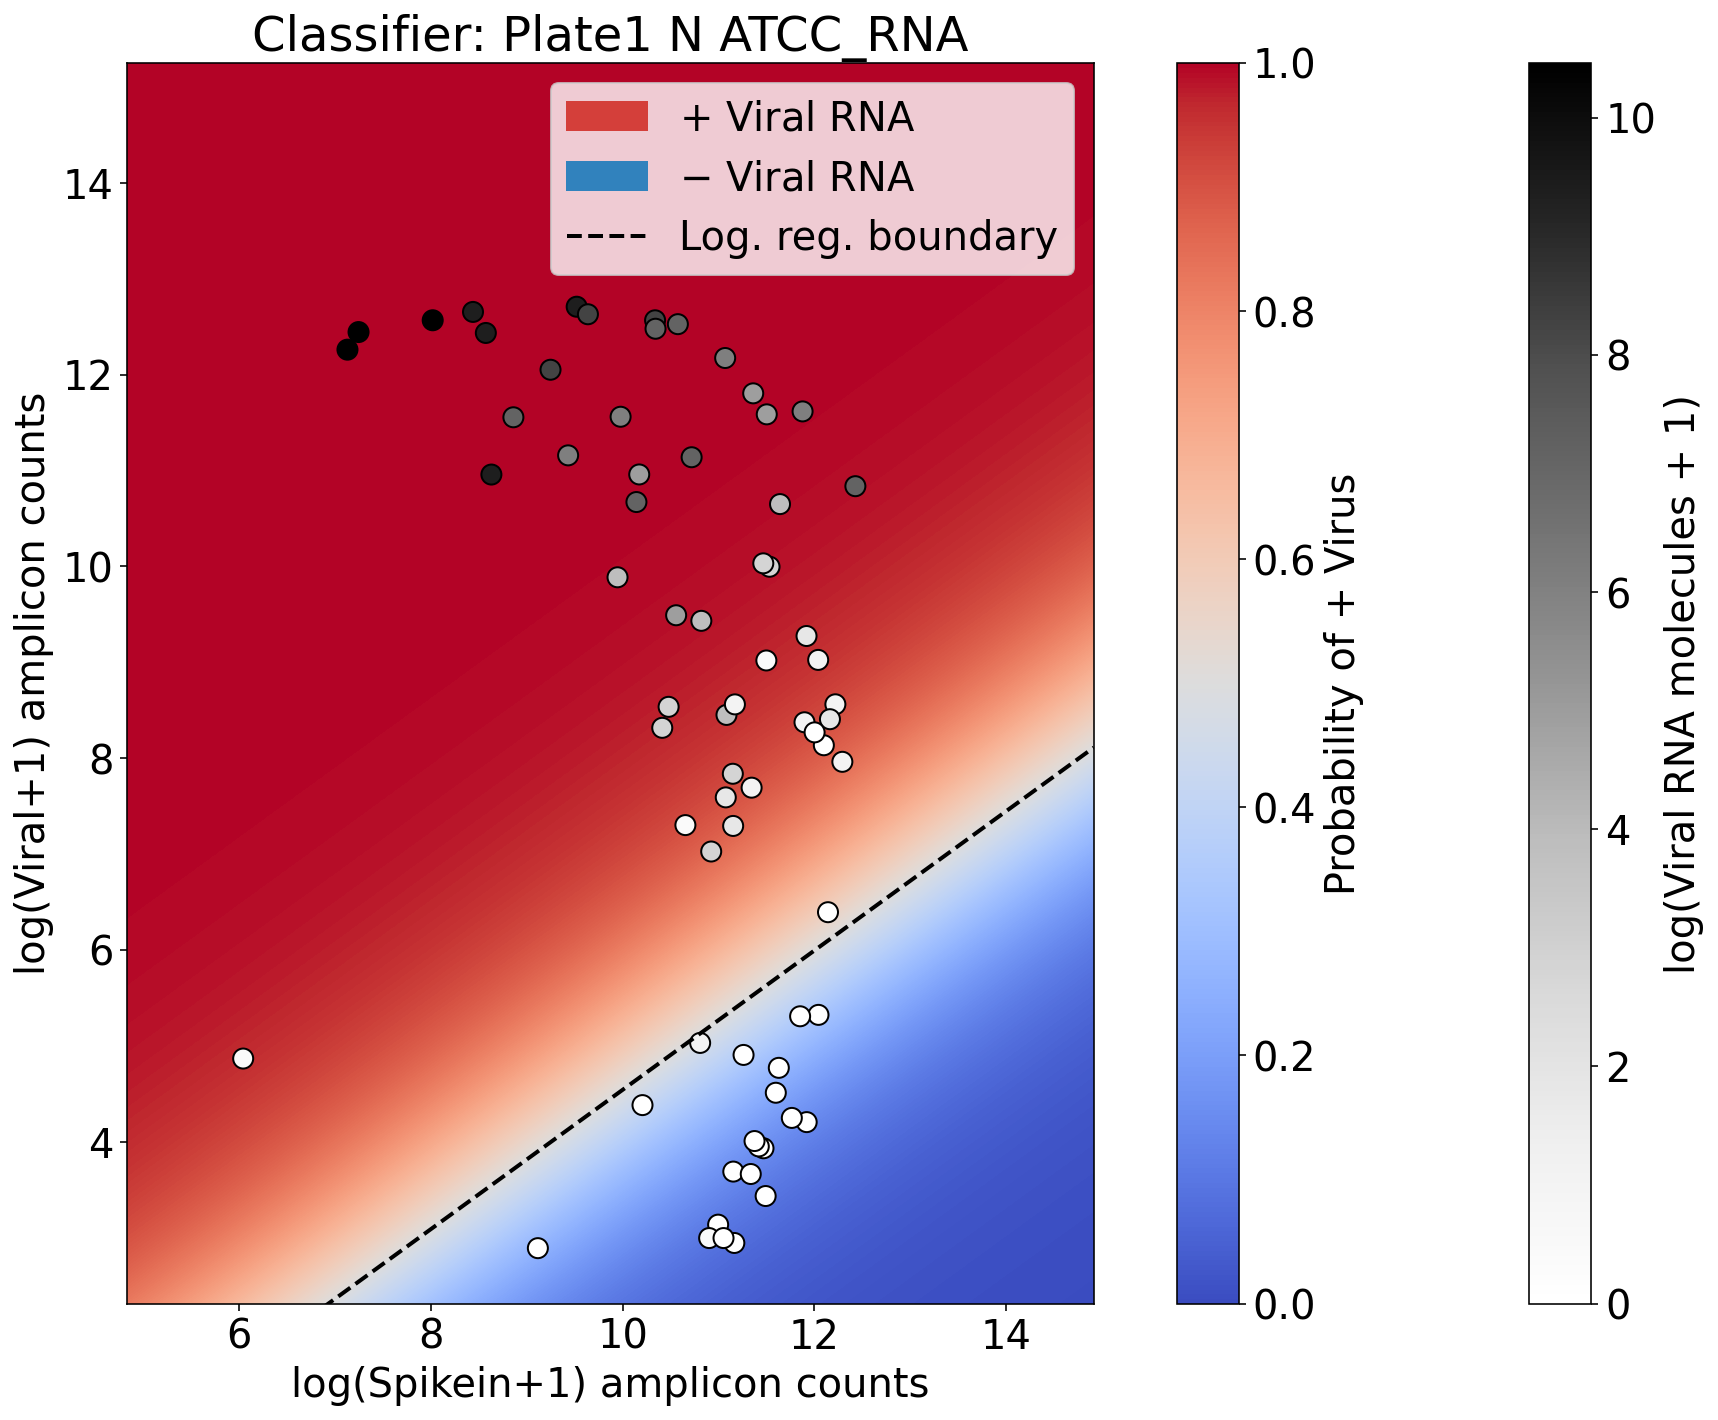

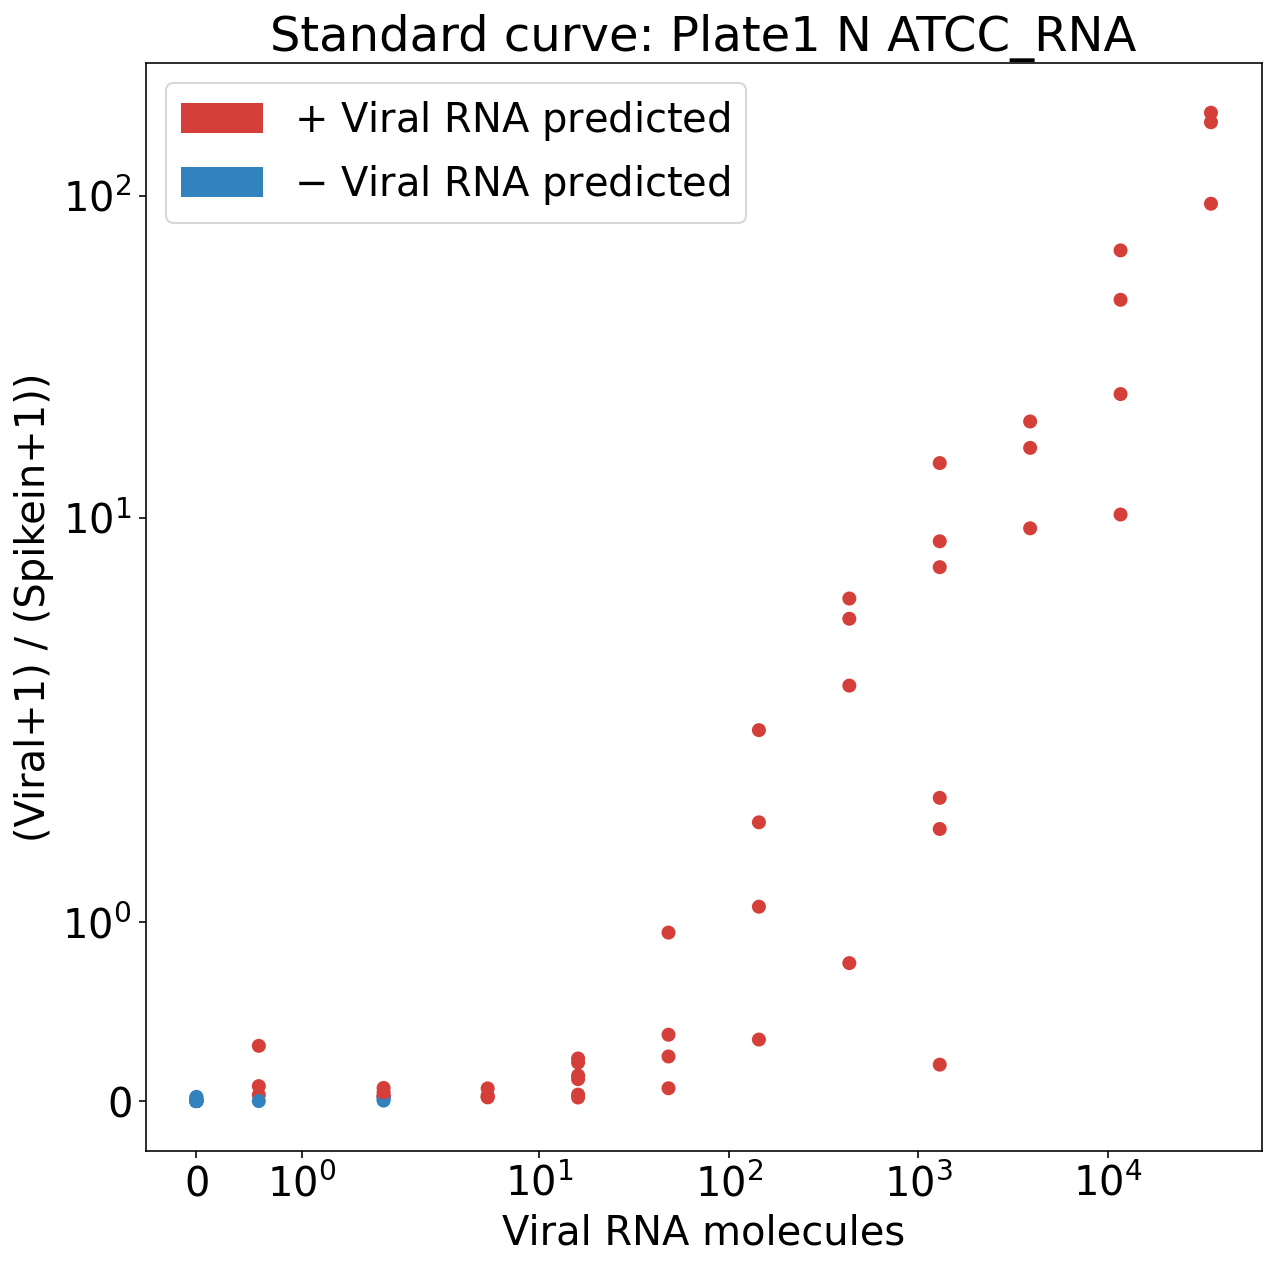

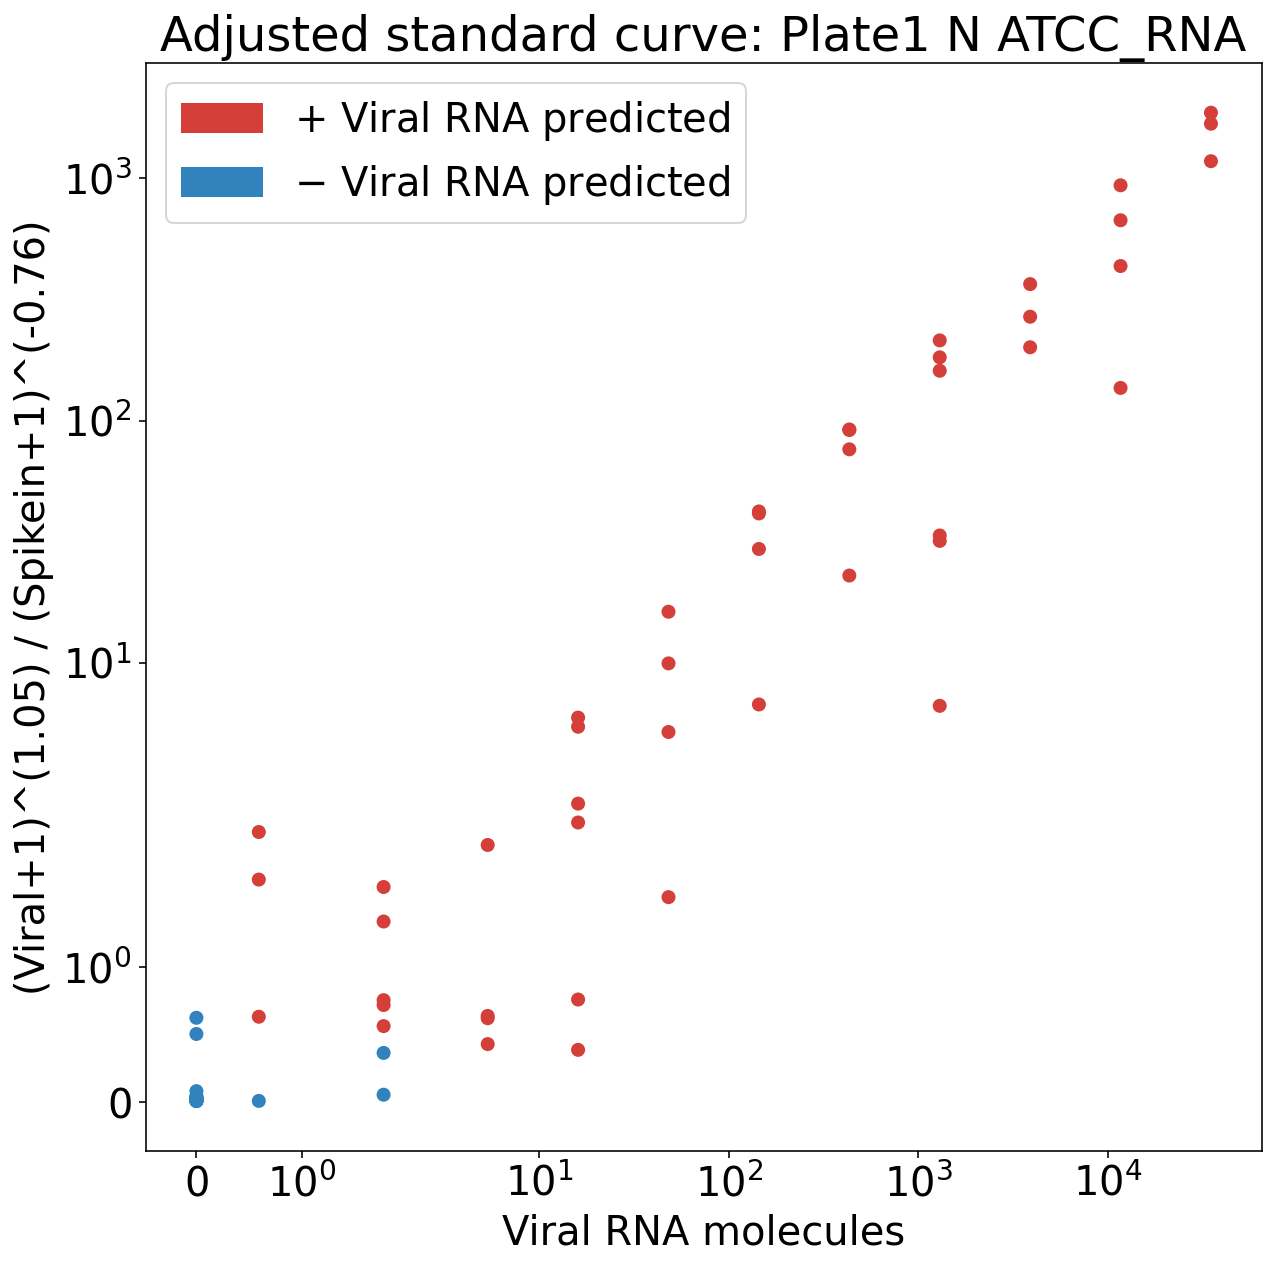

Plate2	HEK293	S	Twist
Score:     0.9375
Precision: 0.9000
Recall:    0.9474


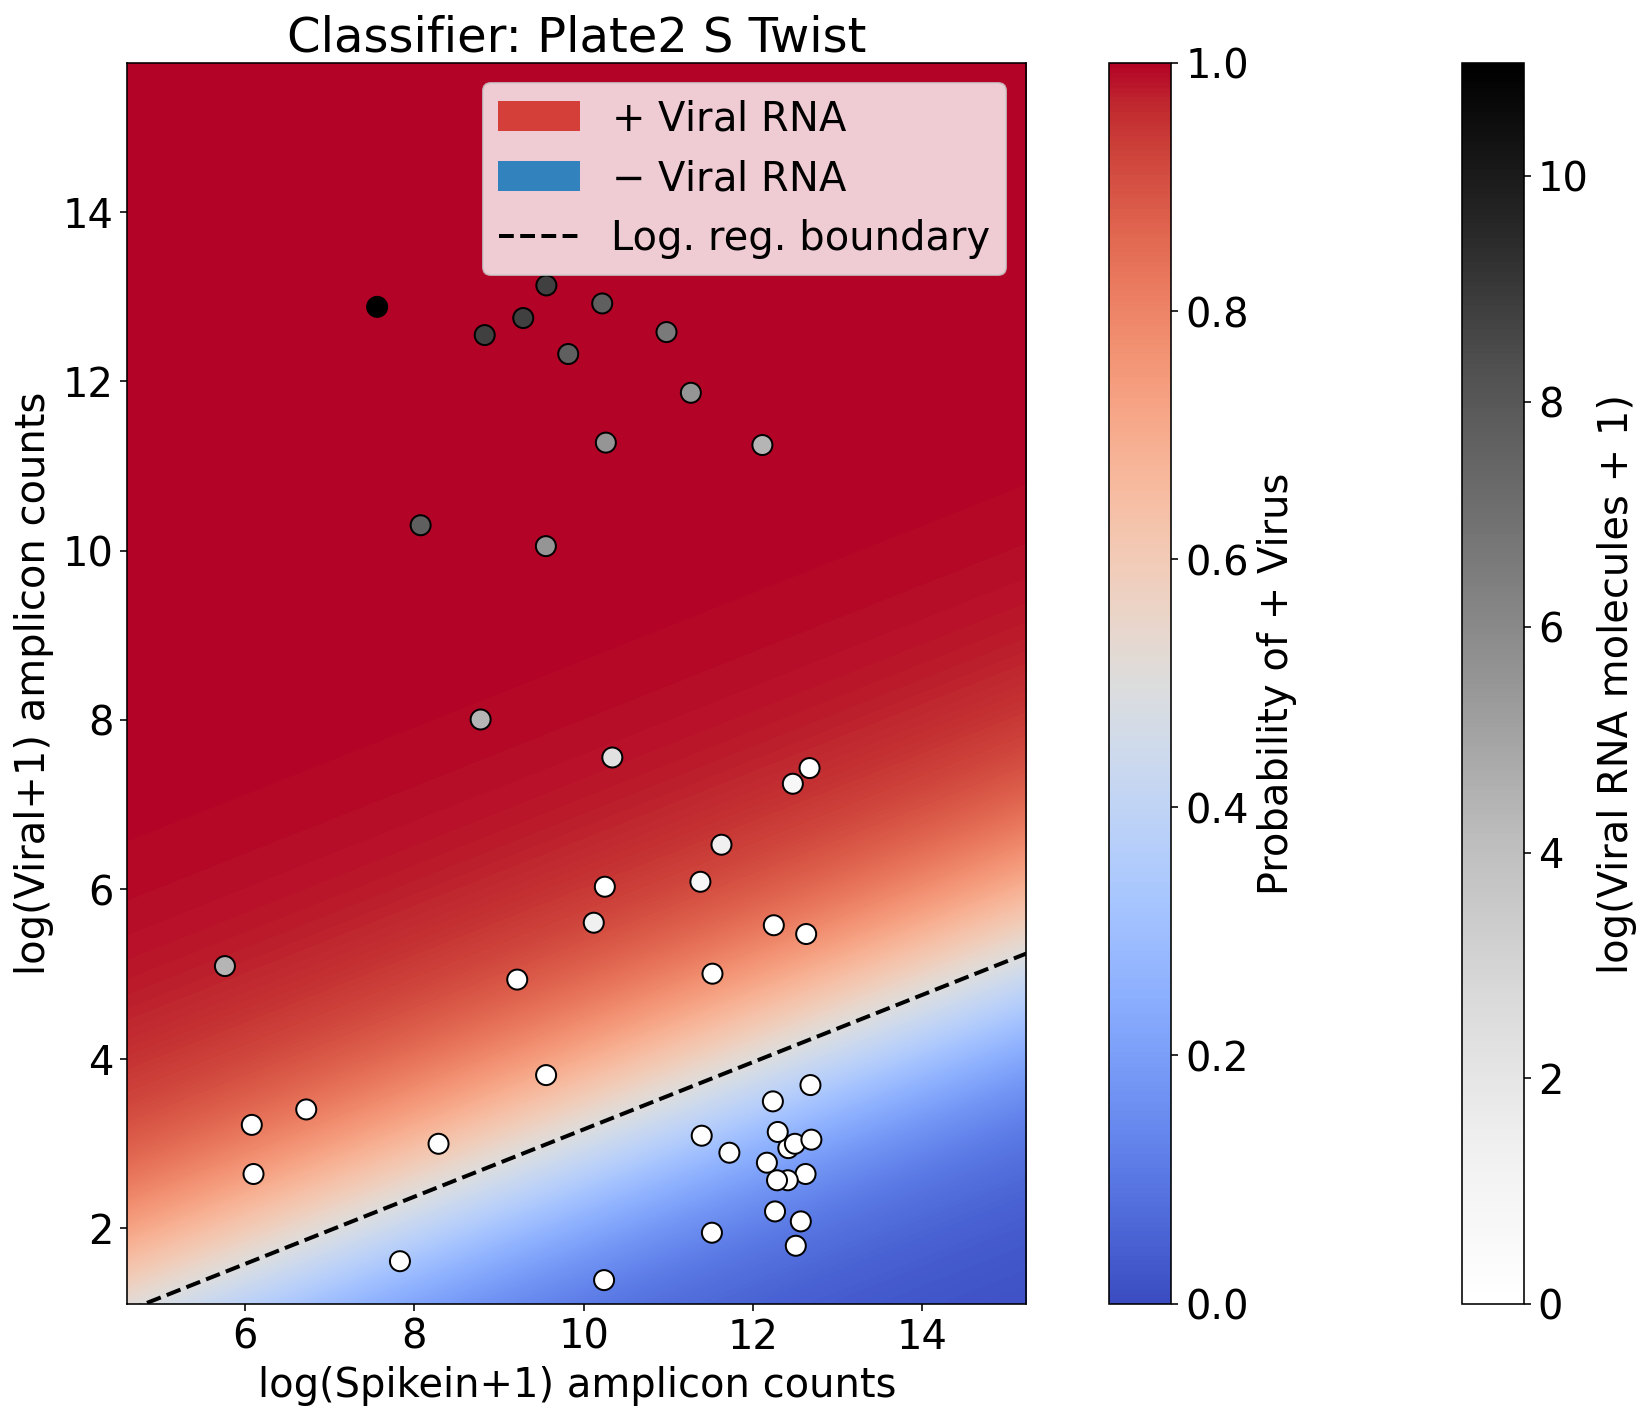

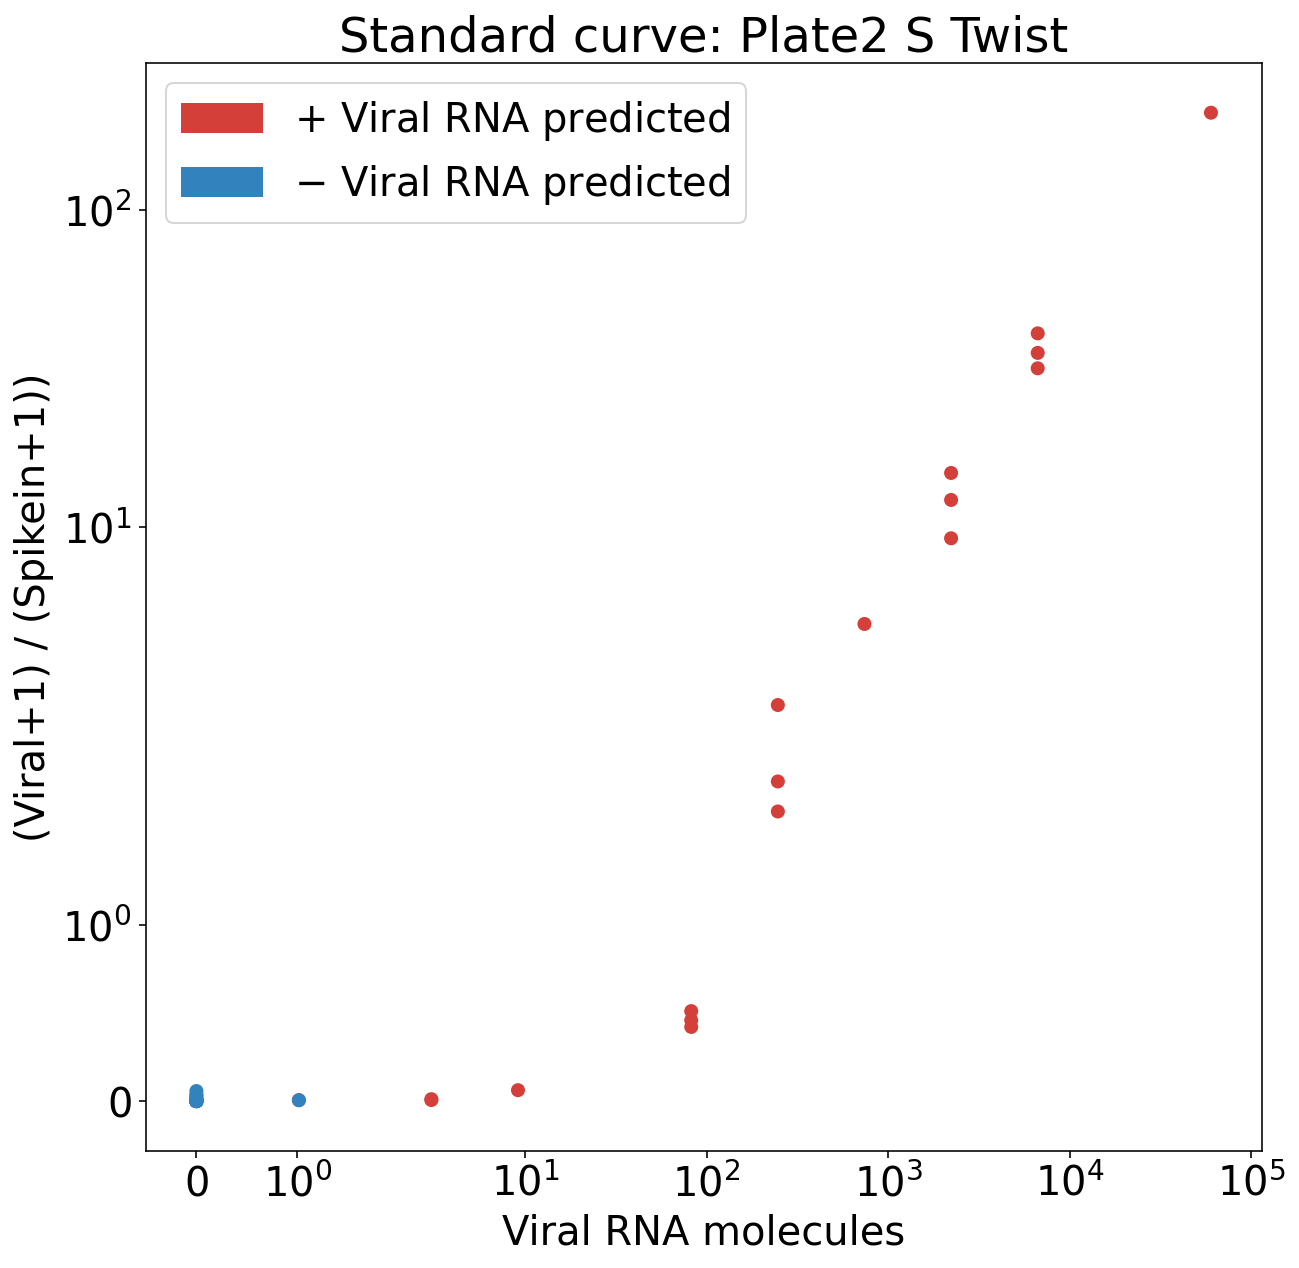

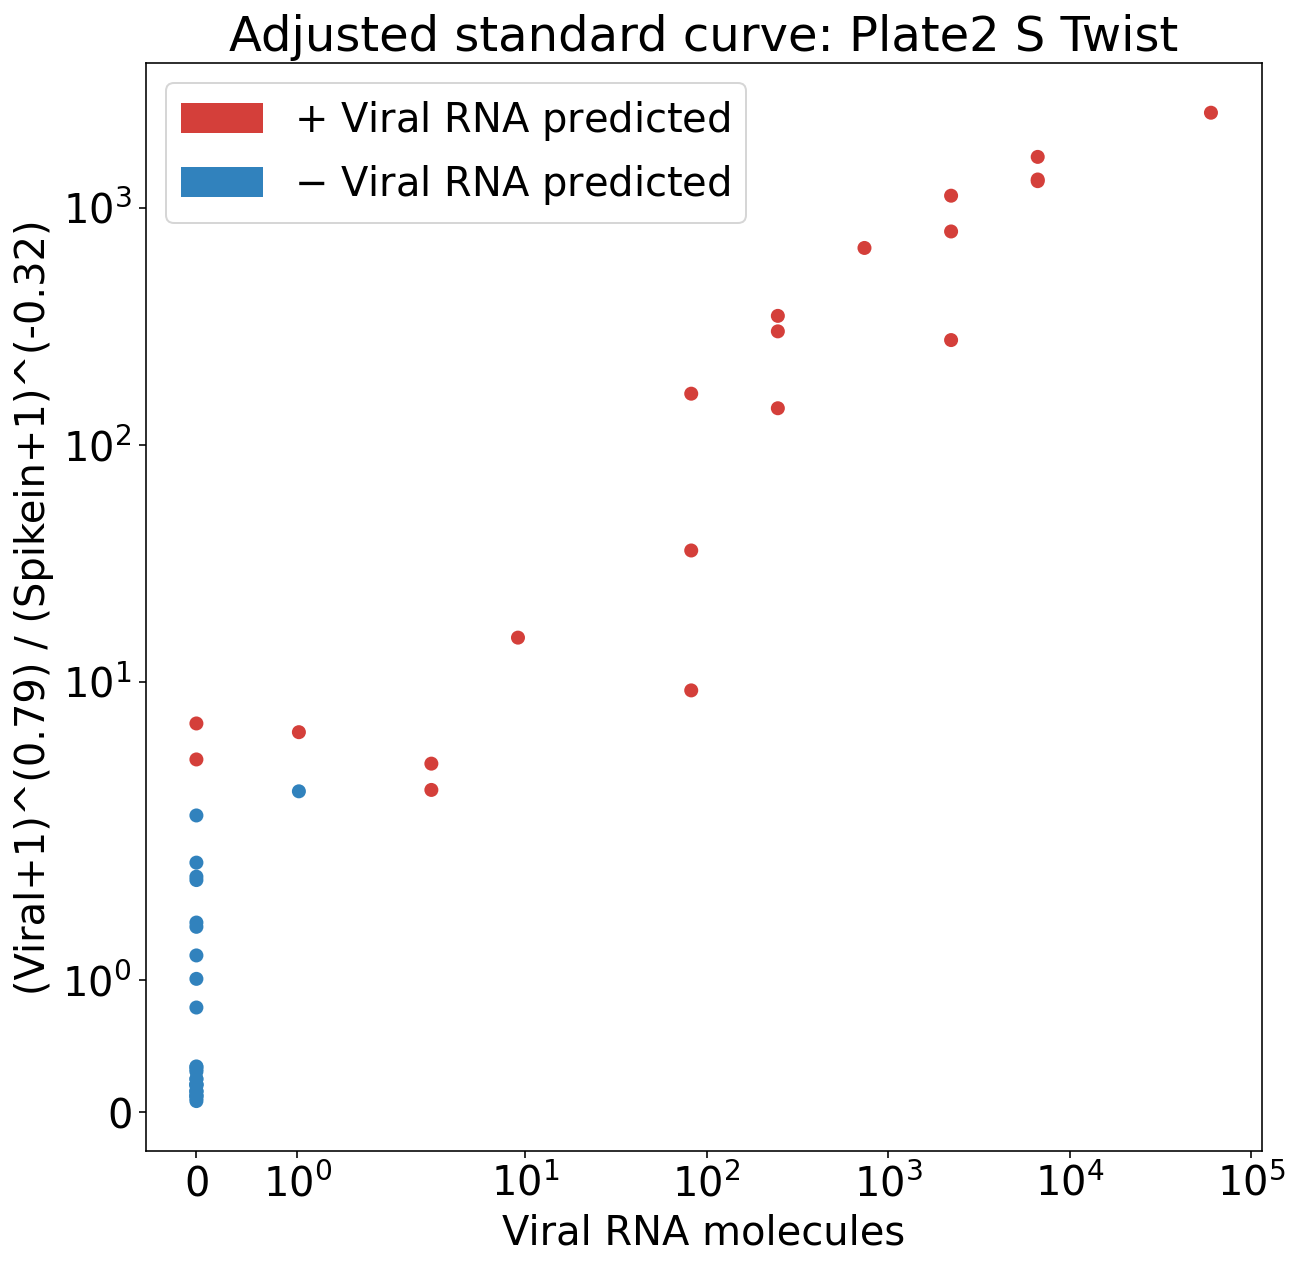

Plate2	HEK293	S	ATCC_RNA
Score:     0.8857
Precision: 0.9767
Recall:    0.8571


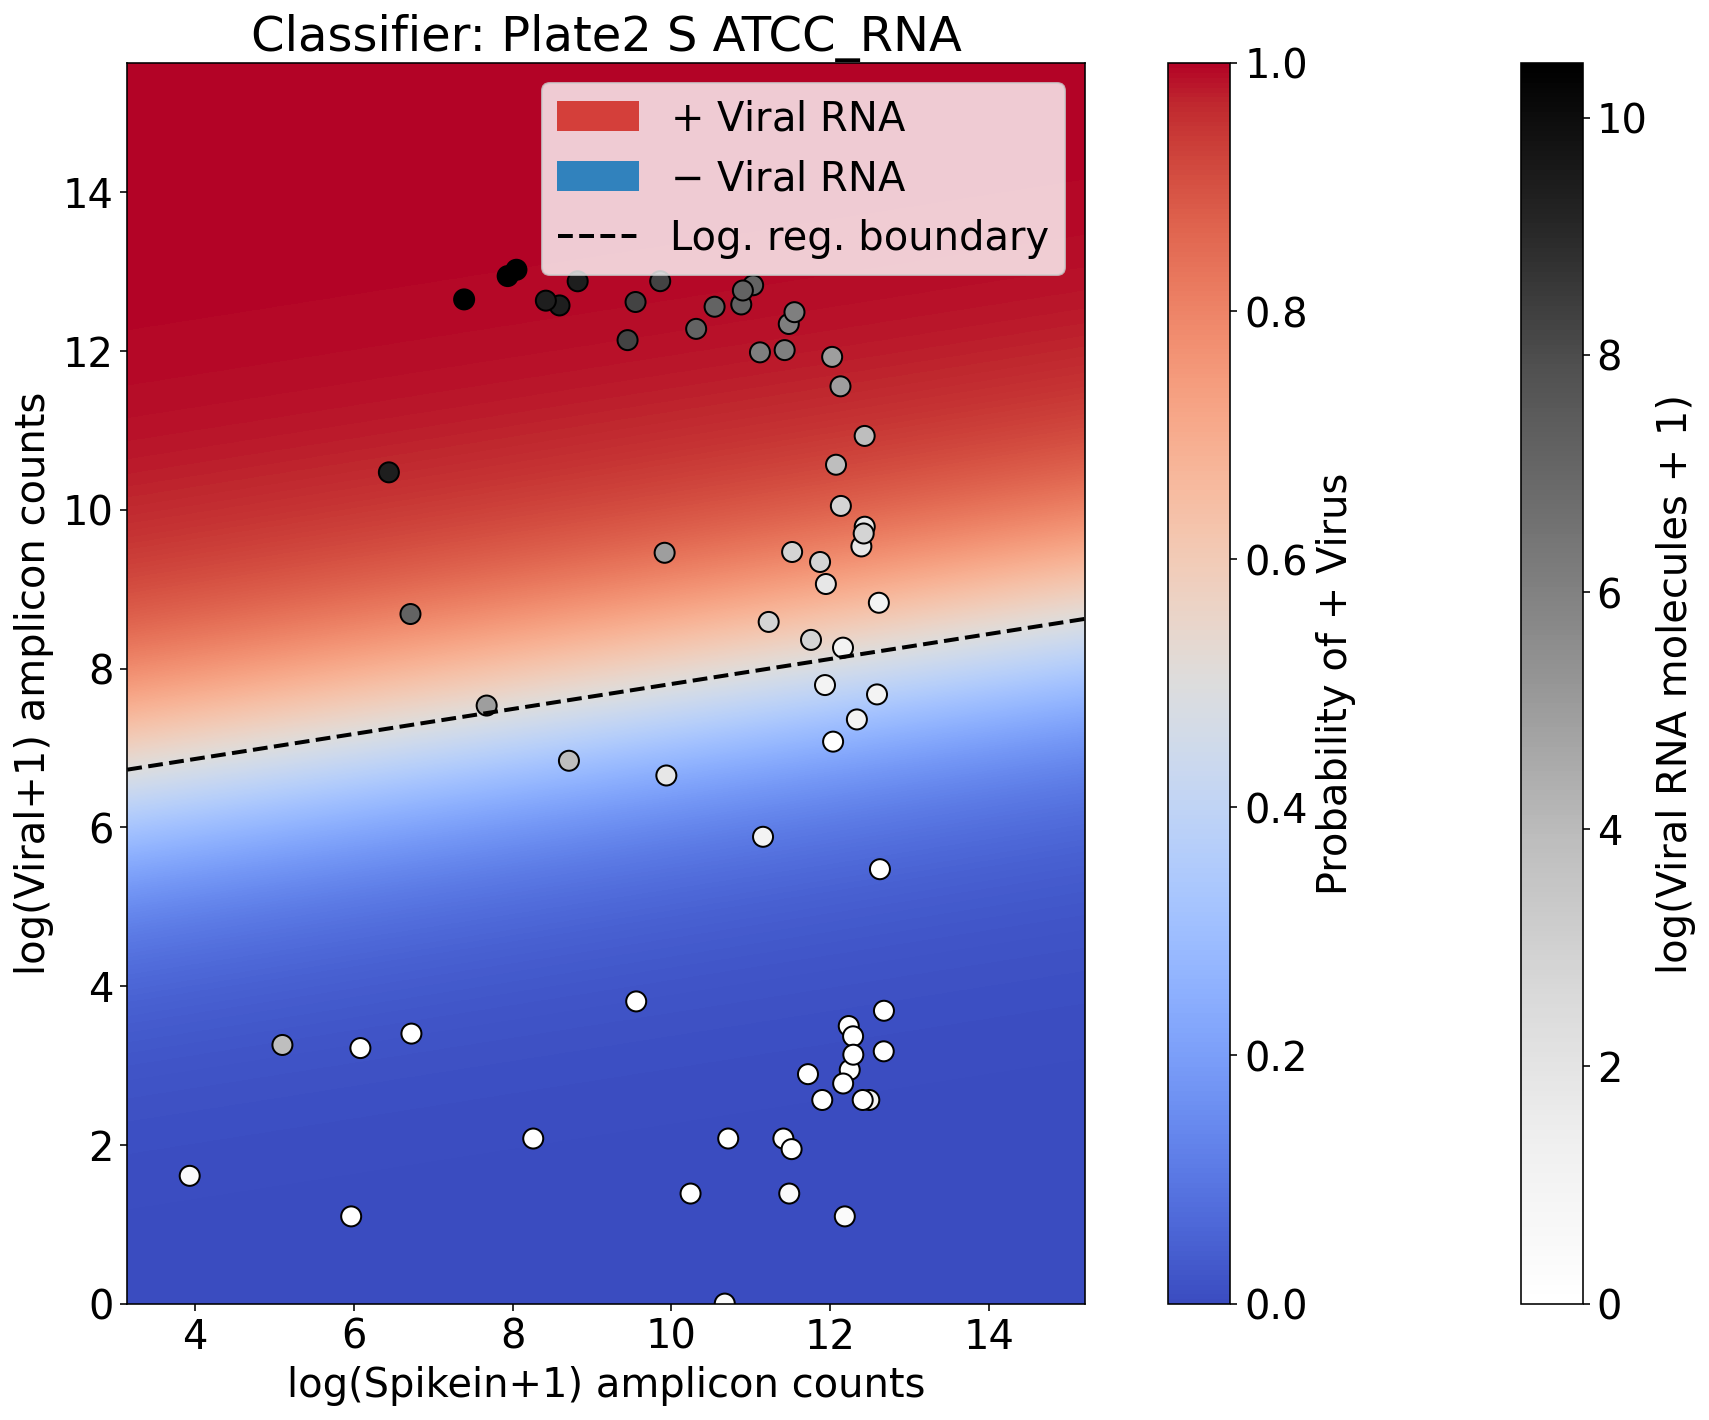

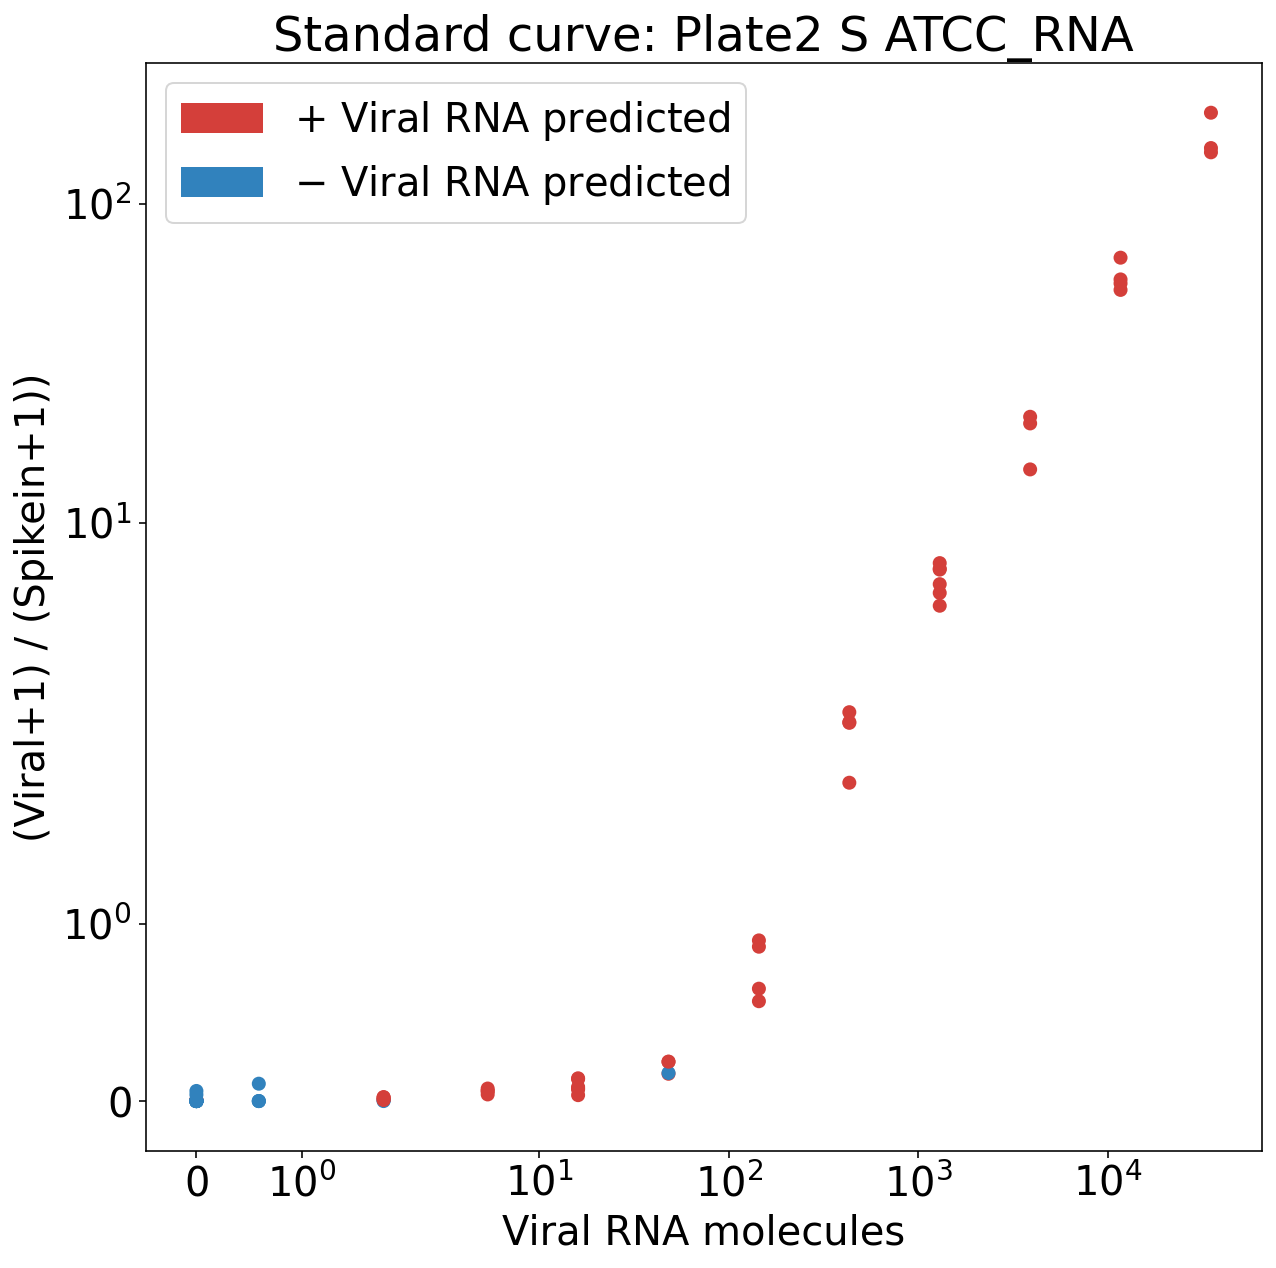

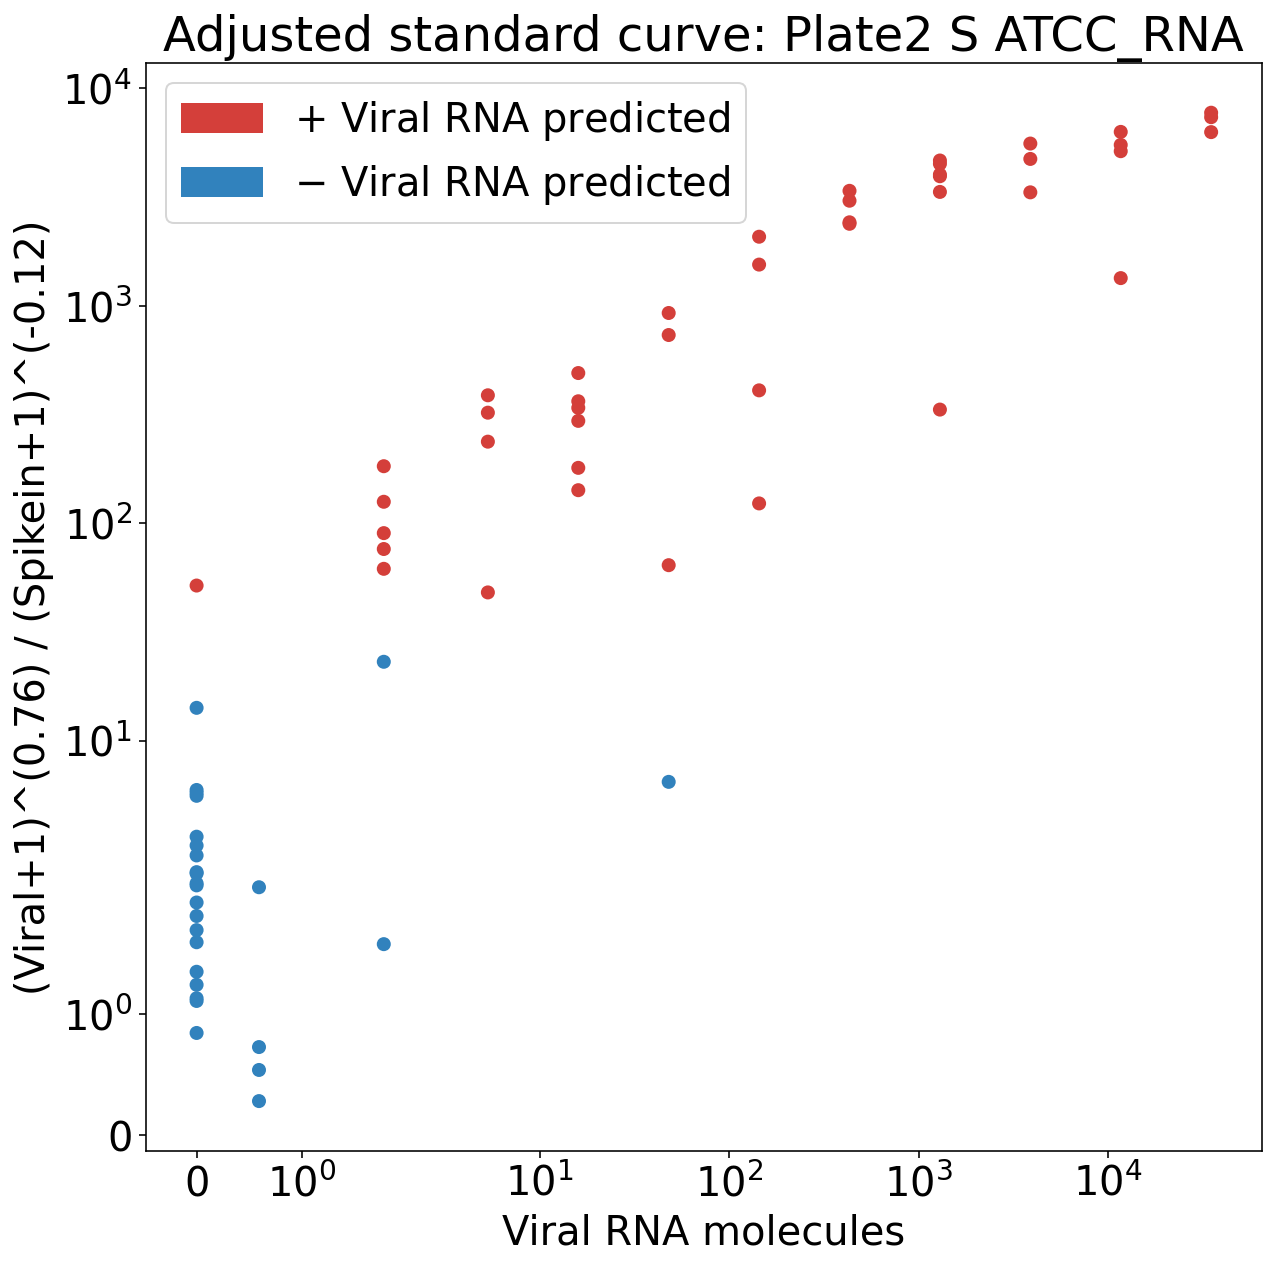

In [17]:
adata = adata[:,adata.var.sort_values("gene").index]
XXX = np.asarray(adata.layers["raw"])
plot_values = []
for (p, l, g, c) in exp:
    pmask = adata.obs.plate.values==p
    cmask = adata.obs[c+"_bool"].values
    lmask = adata.obs.lysate.values==l
    
    m = np.logical_and(np.logical_and(pmask, cmask), lmask)
    vm = np.logical_or(adata.var.gene.str.contains(g), adata.var.gene.str.contains("RPP30")).values
    gene_labels = adata.var.gene.values
    
    XX = XXX[m][:,vm]

    X = np.log1p(XX)
    y1 = nd((adata.obs[m][c]>0).astype(int))
    y2 = nd(adata.obs[m][c].values)

    print("{}\t{}\t{}\t{}".format(p, l, g[0], c))
    (X_train, X_test, y_train, y_test, y_pred, w, b, clf) = main(X, y1, y2)
    ##########################################################    
    fig, ax = plt.subplots(figsize=(15,10))

    xlabel, ylabel = (g+"_spikein", g)
    xidx, yidx = (np.where(gene_labels[vm]==xlabel)[0][0], np.where(gene_labels[vm]==ylabel)[0][0])
        
    plot(X_test, y_test, xidx, yidx, xlabel, ylabel, w, b)
    ax.set_title("Classifier: {} {} {}".format(p, g[0], c))
    #plt.savefig("./figs/log_reg_{}_{}_{}.png".format(p, g, c),bbox_inches='tight', dpi=300)

    
    plt.show()
    ##########################################################
    fig, ax = plt.subplots(figsize=(10, 10))
    
    plot_LOD_normal(X_test, y_test, xlabel, ylabel, xidx, yidx, w, b, y_pred)
    ax.set_title("Standard curve: {} {} {}".format(p, g[0], c))
    #plt.savefig("./figs/lod_norm_{}_{}_{}.png".format(p, g, c),bbox_inches='tight', dpi=300)

    plt.show()
    ##########################################################
    fig, ax = plt.subplots(figsize=(10, 10))
    
    plot_LOD_adjusted(X_test, y_test, xlabel, ylabel, xidx, yidx, w, b, y_pred)
    ax.set_title("Adjusted standard curve: {} {} {}".format(p, g[0], c))
    #plt.savefig("./figs/lod_adj_{}_{}_{}.png".format(p, g, c),bbox_inches='tight', dpi=300)
    plt.show()

# Diagnostic results are reported as probabilities

In [18]:
pd.DataFrame(clf.predict_proba(X_test), columns=["- virus", "+ virus"])

,- virus,+ virus
0,0.988534,0.011466
1,0.005457,0.994543
2,0.975508,0.024492
3,0.005474,0.994526
4,0.057123,0.942877
...,...,...
65,0.003317,0.996683
66,0.053892,0.946108
67,0.119947,0.880053
68,0.305283,0.694717
